## Import libraries

In [725]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from scipy import stats

## Data preprocessing

In [726]:
# Load data
factors = pd.read_csv('datasets/covid-state-data-agg/COVID19_state.csv')
covid_cases = pd.read_csv('datasets/covid-cases-data/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')
state_trips = pd.read_csv('datasets/bts-travel-data/State_trips.csv')
state_code_map = pd.read_csv('datasets/BlueRedStates.csv').drop(columns=['BlueRed'])

In [727]:
# Helper functions 

# This function converts the date column into a datetime object
# and filter by specified year
def filterByYear(df, date_col, year):
    df[date_col] = pd.to_datetime(df[date_col], infer_datetime_format=True)
    return df[df[date_col].dt.strftime('%Y') == year]

#### Covid cases data

In [728]:
covid_cases_cols = ['submission_date', 'state', 'new_case', 'tot_cases']
covid_cases = covid_cases[covid_cases_cols]
covid_cases = filterByYear(covid_cases, 'submission_date', '2020')

# merge NY and NYC data
cases_indexed = covid_cases.groupby(['submission_date','state']).sum()

indexes = cases_indexed.index
date_index = np.unique(np.array([ind[0] for ind in indexes]))

for date_ind in date_index: 
    cases_indexed.loc[date_ind, 'NY'] = cases_indexed.loc[date_ind, 'NY'] + cases_indexed.loc[date_ind, 'NYC']
    
cases_indexed.reset_index(inplace=True, level=['submission_date', 'state'])

new_cases = cases_indexed

#### Trips data

In [729]:
# state trips data 
state_trips_col = ['Date', 
                   'State Postal Code', 
                   'Number of Trips', 
                   'Number of Trips 5-10', 
                   'Number of Trips 25-50', 
                   'Number of Trips 100-250', 
                   'Number of Trips 250-500']
state_trips = state_trips[state_trips_col]
state_trips = filterByYear(state_trips, 'Date', '2020')

#### Population data

In [730]:
# get population by state
factors = factors[['State', 'Population']]
pop_by_state = state_code_map.merge(factors, left_on='stateName', right_on='State')\
    .drop(columns=['stateName', 'State'])\
    .rename(columns={'stateCode' : 'state'})

#### Join all data

In [731]:
# rename so the merge is valid
new_cases.rename(columns={'submission_date' : 'date'}, inplace=True)
state_trips.rename(columns={'Date' : 'date', 'State Postal Code' : 'state'}, inplace=True)

# merge all dfs
new_case_trips = new_cases.merge(state_trips, on=['date', 'state'], how='inner')
final_data = new_case_trips.merge(pop_by_state, on='state', how='inner')
final_data.replace(',','', regex=True, inplace=True)


# normalize number of trips 
num_trips_cols = ['Number of Trips', 'Number of Trips 5-10', 'Number of Trips 25-50', 'Number of Trips 100-250', 'Number of Trips 250-500']
for col in num_trips_cols:
    final_data[col] = final_data[col].astype(float) / final_data['Population']

# normalize num of new cases
final_data['new_case_ratio'] = final_data['new_case']  / final_data['Population']
final_data['tot_case_ratio'] = final_data['tot_cases']  / final_data['Population']

## Hypothesis testing

In [732]:
# This function does median split based a given values in `sr`
# and split `df` into two groups
def medianSplitGroups(sr, df, col):
    median = sr.median()
    print(f"median value: {median}")
    group1 = []
    group2 = []

    for i in range(len(sr)):
        if sr[i] < median:
            group1.append(sr.index[i])
        else:
            group2.append(sr.index[i])
            
    group1Df = df[df[col].isin(group1)]
    group2Df = df[df[col].isin(group2)]
            
    # collapse the columns in each group into one column
    return (group1Df, group2Df)

# Find median of num trips in each state 
numTripsByState = final_data.groupby('state').sum()['Number of Trips']
(lessTravelled, moreTravelled) = medianSplitGroups(numTripsByState, final_data, 'state')

lessTravelledByState = lessTravelled.groupby('state').sum()['new_case_ratio'].reset_index()
moreTravelledByState = moreTravelled.groupby('state').sum()['new_case_ratio'].reset_index()

median value: 1055.940446343205


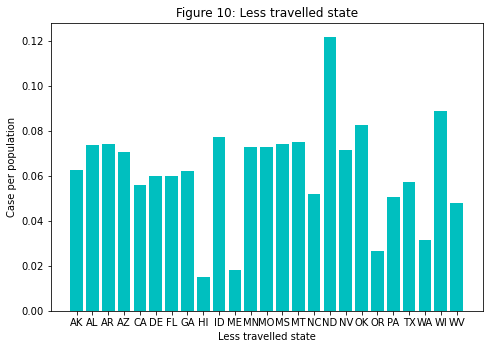

In [735]:
fig = plt.figure(1)
ax = fig.add_axes([0,0,1,1])
ax.bar(lessTravelledByState['state'], lessTravelledByState['new_case_ratio'], color='c')
plt.title('Figure 10: Less travelled state')
plt.xlabel('Less travelled state')
plt.ylabel('Case per population')
plt.show()

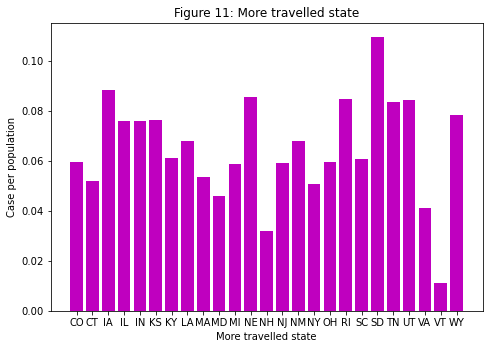

In [736]:
fig = plt.figure(1)
ax = fig.add_axes([0,0,1,1])
ax.bar(moreTravelledByState['state'], moreTravelledByState['new_case_ratio'], color='m')
plt.title('Figure 11: More travelled state')
plt.xlabel('More travelled state')
plt.ylabel('Case per population')
plt.show()

In [43]:
# Run an independent t-test
stats.ttest_ind(moreTravelled['new_case_ratio'], lessTravelled['new_case_ratio'], alternative='greater')

Ttest_indResult(statistic=1.9745353618821533, pvalue=0.024168413093197377)